# Load Data

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import notebook
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
(x_train,_),(x_val,_) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
data = np.vstack([x_train, x_val])

In [ ]:
data = (data.astype('float32') - 127.5) / 127.5

In [ ]:
data = data.reshape(-1,784)

In [ ]:
adam = Adam(learning_rate= 0.0002, beta_1= 0.5)

# Structure of the generative network

The first thing that we need to do to code both the GAN is to know the structure of both the generator and the discriminator. The input of the generative network is a vector of noise. We will upscale this network until making them a 28x28x1 array.

The idea of the network is simple: from the random noise, we will convolve the data until we generate an image. In the beginning, the images will be random noise too, but the more we train the generative network, the better the results will be.

Now that we have the idea clear, let’s code it!

# Coding the generative network

The first thing we need to do is to load the functions that we will use. In this case, I will use:

- Dense: it’s the noise layer of our generator.
- Conv2DTranspose: this enables to convolve backwards, that is, to upscale and convolve the image at the same time. It is the equivalent of using the function - UpSampling2D followed by Conv2D.
- LeakyReLU: it is better than the ReLU functions, because it avoids gradient vanish. You can read more about this on this paper.
- BatchNormalization: it enables to normalize the result of a convolution. This will help us get better results. In my case, I haven’t used it because, after trying it, it did not improve the results.
- Reshape: this enables us to transform a one-dimensional vector into a three-dimensional array.

Besides we have to take into account that the shape of the output of the generative network has to be the same as the shape of the real images. To achieve that we will use the function Conv 2DTranspose, but, how do we know what shape will we get?

In that regard, we will use the strides. The strides refer to how much does the kernel move in order to make the convolution. For example, in the case of an 18 by 18 images, if we apply a convolution with a kernel of 3 and a stride of 3, the final result will be an image of 6 by 6 (18/3 x 18/3).

Inversely, if we want to increase the size of an image using Conv2DTranspose, we will use to have the strides too. For example, if we want to pass from a 6 by 6 images to a 18 by 18 image, we will need to keep a strides of 1.

On the other hand, on the last layer, we will use the tangent function so that we get values from -1 to 1. The reason? Try and error. I first tried the sigmoid function but it did not work that well.

Lastly, it is important to remark that we are just defining the structure of the generative network. We are not trying to train it.

In [ ]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, Sequential

def generator(dim_noise = 100):
    input = Input(dim_noise)
    x = Dense(7 * 7 * 256)(input)
    x = LeakyReLU(0.2)(x)
    x = Reshape((7,7,256))(x)
    
    x = Conv2DTranspose(128, kernel_size= (3,3), strides= 2, padding= 'same')(x) # 14
    
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size= (4,4), strides= 2, padding= 'same')(x) # 28
    
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size= (4,4), strides= 1, padding= 'same', activation= 'tanh')(x)
    x = Flatten()(x)
    return Model(input, x, name = 'generator_model')

g = generator()
g.summary()

Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                   

# Coding the discriminator network

Our discriminator network is a normal convolutional neural network. It will take an image as input and as output will return a binary value.

Despite in convolutional network, it is recommended to use dropout layers after each convolution to avoid overfitting. 

On the other hand, on this network, we will use the sigmoid activation function in the last layer. When we want to classify two images, the sigmoid activation functions is giving the probability of an image being of the target group.

When it comes to the optimizer, we will use Adam optimizer, as it works especially well with big datasets and usually works better than Gradient Descent

In [ ]:
def discriminator():
    input = Input(shape = (28 * 28))
    x = Reshape((28,28,1))(input)
    x = Conv2D(128, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14

    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(256, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
   
    x = LeakyReLU(0.2)(x)
     
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    return Model(input, x, name = 'discriminator')
d = discriminator()
d.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       3328      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)           

# GAN creation

Now that we have all the pieces of our generative adversarial network we have to put them together so that the generator generates images and the discriminator classifies if the images are real or not.

In [ ]:
g.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])
d.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])

d.trainable = False

gan_model = Sequential([g, d])
gan_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
gan_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_model (Functional  (None, 784)              1694145   
 )                                                               
                                                                 
 discriminator (Functional)  (None, 1)                 835329    
                                                                 
Total params: 2,529,474
Trainable params: 1,694,145
Non-trainable params: 835,329
_________________________________________________________________


In [ ]:
def show_example(gan_model):
    noise = np.random.normal(size = (10,100))
    image_generate = gan_model.layers[0](noise).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

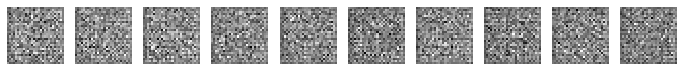

In [ ]:
# test code
show_example(gan_model)

# Train

In [ ]:
Loss_g, Loss_d = [], []
def train(gan_model, image, batch_size = 256, epochs = 100, verbose = 1):
    interation = int(len(image) / batch_size)
    for i in range(1, epochs + 1):
        if i % verbose == 0:
            print(f'Epochs {i}: ', end= '')
        indexes = np.arange(len(image))
        indexes = shuffle(indexes)
        fake_acc, real_acc = [], []
        loss_D, loss_G = [], []
        for j in notebook.tqdm(range(interation)):
            index = indexes[j * batch_size : (j + 1) * batch_size]
            real_img = np.array([image[k] for k in index])
            
            # sinh ảnh từ noise
            noise = np.random.normal(size = (batch_size, 100))
            fake_img = gan_model.layers[0](noise)
        
            # nhiễu label
            y = np.ones(batch_size * 2)
            y[:batch_size] = 0.9 # real_img
            y[batch_size:] = 0.1 # fake_img
            # train discriminator
            gan_model.layers[1].trainable = True
            # train real_img
            loss_real = gan_model.layers[1].train_on_batch(real_img,y[:batch_size])
            loss_fake = gan_model.layers[1].train_on_batch(fake_img,y[batch_size:])
            
            loss_d = 0.5 * np.add(loss_real, loss_fake)
            
            loss_D.append(loss_d)
            
            fake_acc.append(loss_fake[1])
            real_acc.append(loss_real[1])
            # train generator
            fake_img = np.random.normal(size = (batch_size, 100))
            y_fake = np.ones(batch_size)
            gan_model.layers[1].trainable = False
            loss_g = gan_model.train_on_batch(fake_img,y_fake)
            loss_G.append(loss_g)

        if i % verbose == 0:
            show_example(gan_model)
            print('d_loss: %f   g_loss: %f' % (np.array(loss_D).mean(), np.array(loss_G).mean()))
            Loss_d.append(np.array(loss_D).mean())
            Loss_g.append(np.array(loss_G).mean())

Epochs 1: 

  0%|          | 0/273 [00:00<?, ?it/s]

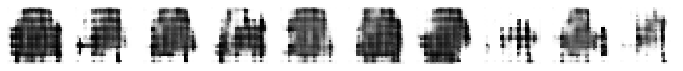

d_loss: 0.059911   g_loss: 0.257867
Epochs 2: 

  0%|          | 0/273 [00:00<?, ?it/s]

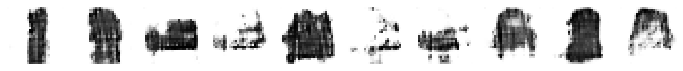

d_loss: 0.063389   g_loss: 0.229397
Epochs 3: 

  0%|          | 0/273 [00:00<?, ?it/s]

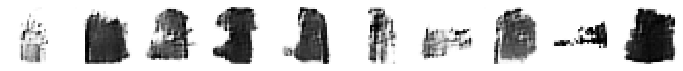

d_loss: 0.068114   g_loss: 0.235676
Epochs 4: 

  0%|          | 0/273 [00:00<?, ?it/s]

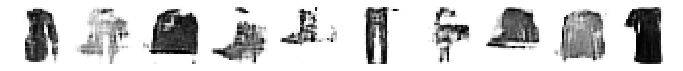

d_loss: 0.074707   g_loss: 0.243526
Epochs 5: 

  0%|          | 0/273 [00:00<?, ?it/s]

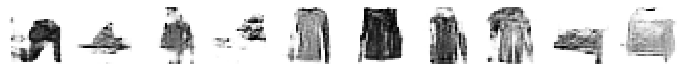

d_loss: 0.075810   g_loss: 0.241407
Epochs 6: 

  0%|          | 0/273 [00:00<?, ?it/s]

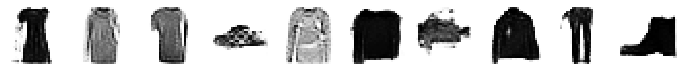

d_loss: 0.076290   g_loss: 0.242038
Epochs 7: 

  0%|          | 0/273 [00:00<?, ?it/s]

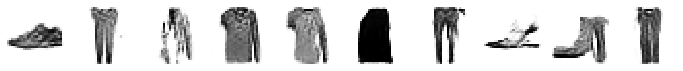

d_loss: 0.076290   g_loss: 0.249089
Epochs 8: 

  0%|          | 0/273 [00:00<?, ?it/s]

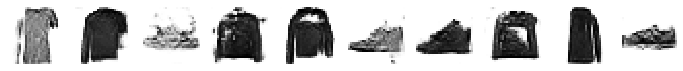

d_loss: 0.076428   g_loss: 0.253069
Epochs 9: 

  0%|          | 0/273 [00:00<?, ?it/s]

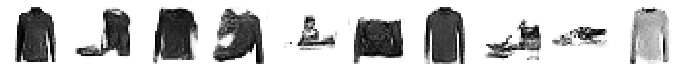

d_loss: 0.076447   g_loss: 0.254531
Epochs 10: 

  0%|          | 0/273 [00:00<?, ?it/s]

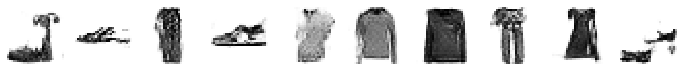

d_loss: 0.076494   g_loss: 0.256013
Epochs 11: 

  0%|          | 0/273 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
train(gan_model, data)

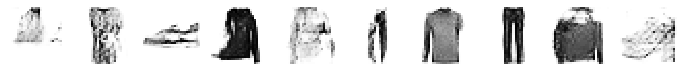

In [ ]:
show_example(gan_model)

In [ ]:
noise = np.random.normal(size = (10,100))
noise = np.ones((1,100))
image_generate = gan_model.layers[0](noise).numpy().reshape(-1,28,28)

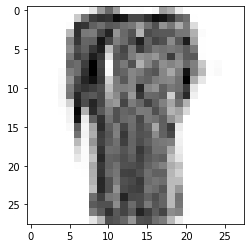

In [ ]:
plt.imshow(image_generate[0],interpolation='nearest',cmap='gray_r')

In [ ]:
def show_example(gan_model):
    noise = np.random.normal(size = (10,100))
    image_generate = gan_model.layers[0](noise).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 36.6 MB/s 


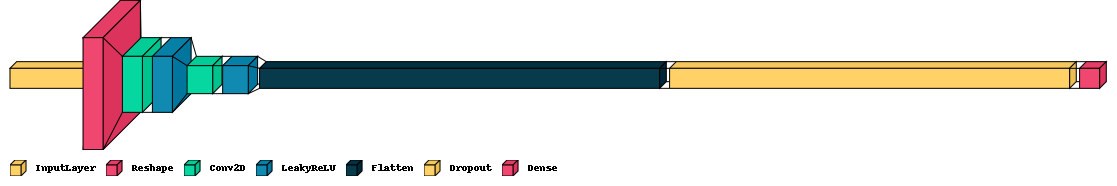

In [ ]:
import visualkeras

visualkeras.layered_view(d,legend=True, draw_volume=True)

In [ ]:
gan_model.save('gan_fashionmnist.h5')